In [ ]:
from pathlib import Path
from bnn.model import BayesianMensa
from tools.data_loader import get_data_loader
import torch
import math
from utility.config import dotdict, load_config
from utility.survival import make_time_bins, preprocess_data
from bnn.utility import make_ensemble_mensa_prediction
from SurvivalEVAL.Evaluations.util import predict_median_survival_time
from SurvivalEVAL.Evaluator import LifelinesEvaluator
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                    'axes.titlesize': 'medium',
                    'font.size': 14.0,
                    'text.usetex': True,
                    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})
import seaborn as sns
import config as cfg
import numpy as np
import pandas as pd
import random

from utility.plot import load_tf_color
TFColor = load_tf_color()

N_SAMPLES_TRAIN = 10
N_SAMPLES_TEST = 100

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Setup precision
dtype = torch.float64
torch.set_default_dtype(dtype)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
dl = get_data_loader("proact").load_data()
train_dict, valid_dict, test_dict = dl.split_data(train_size=0.7, valid_size=0.1,
                                                  test_size=0.2, random_state=0)
n_events = dl.n_events

# Preprocess data
cat_features = dl.cat_features
num_features = dl.num_features
event_cols = [f'e{i+1}' for i in range(n_events)]
time_cols = [f't{i+1}' for i in range(n_events)]
X_train = pd.DataFrame(train_dict['X'], columns=dl.columns)
X_valid = pd.DataFrame(valid_dict['X'], columns=dl.columns)
X_test = pd.DataFrame(test_dict['X'], columns=dl.columns)
X_train, X_valid, X_test= preprocess_data(X_train, X_valid, X_test, cat_features,
                                          num_features, as_array=True)
train_dict['X'] = torch.tensor(X_train, device=device, dtype=dtype)
train_dict['E'] = torch.tensor(train_dict['E'], device=device, dtype=torch.int64)
train_dict['T'] = torch.tensor(train_dict['T'], device=device, dtype=torch.int64)
valid_dict['X'] = torch.tensor(X_valid, device=device, dtype=dtype)
valid_dict['E'] = torch.tensor(valid_dict['E'], device=device, dtype=torch.int64)
valid_dict['T'] = torch.tensor(valid_dict['T'], device=device, dtype=torch.int64)
test_dict['X'] = torch.tensor(X_test, device=device, dtype=dtype)
test_dict['E'] = torch.tensor(test_dict['E'], device=device, dtype=torch.int64)
test_dict['T'] = torch.tensor(test_dict['T'], device=device, dtype=torch.int64)

# Make time bins
time_bins = make_time_bins(train_dict['T'].cpu(), event=None, dtype=dtype).to(device)
time_bins = torch.cat((torch.tensor([0]).to(device), time_bins))

# Make model
config = dotdict(load_config(cfg.BAYESIAN_CONFIGS_DIR, f"proact.yaml"))
n_epochs = config['n_epochs']
n_dists = config['n_dists']
lr = config['lr']
batch_size = config['batch_size']
layers = config['layers']
n_features = train_dict['X'].shape[1]
model = BayesianMensa(n_features, n_dists, layers=layers,
                      n_events=n_events, config=config)

# Load state
model.load_state_dict(torch.load(Path.joinpath(cfg.MODELS_DIR, 'model.pth')))
model.eval()

In [46]:
# Make predictions
X_test = test_dict['X']
mean_preds, ensemble_preds = [], []
for i in range(n_events):
    survival_outputs, time_bins, ensemble_outputs = make_ensemble_mensa_prediction(model, X_test, time_bins,
                                                                                   risk=i, n_dists=n_dists,
                                                                                   config=config)
    mean_model_preds = pd.DataFrame(survival_outputs, columns=time_bins.cpu().numpy())
    mean_preds.append(mean_model_preds)
    ensemble_preds.append(ensemble_outputs)

In [71]:
sample_idx = 0
n_events = dl.n_events
event_mean_outputs, event_lower_outputs, event_upper_outputs = [], [], []
event_sample_tte, event_median_survival_times = [], []
for event_id in range(n_events):
    sample_tte = test_dict['T'][sample_idx, event_id]
    sample_surv_times = ensemble_preds[event_id][:,sample_idx,:]
    lifelines_eval = LifelinesEvaluator(mean_preds[event_id].T,
                                        test_dict['T'][event_id],
                                        test_dict['E'][event_id],
                                        train_dict['T'][event_id],
                                        train_dict['E'][event_id])
    median_survival_time = lifelines_eval.predict_time_from_curve(predict_median_survival_time)
    sample_median_survival_time = median_survival_time[sample_idx]
    drop_num = math.floor(0.5 * N_SAMPLES_TEST * (1 - 0.9))
    mean_outputs = sample_surv_times.mean(dim=0)
    lower_outputs = torch.kthvalue(sample_surv_times, k=1 + drop_num, dim=0)[0]
    upper_outputs = torch.kthvalue(sample_surv_times, k=N_SAMPLES_TEST - drop_num, dim=0)[0]
    
    event_mean_outputs.append(mean_outputs)
    event_lower_outputs.append(lower_outputs)
    event_upper_outputs.append(upper_outputs)
    event_sample_tte.append(sample_tte)
    event_median_survival_times.append(sample_median_survival_time)

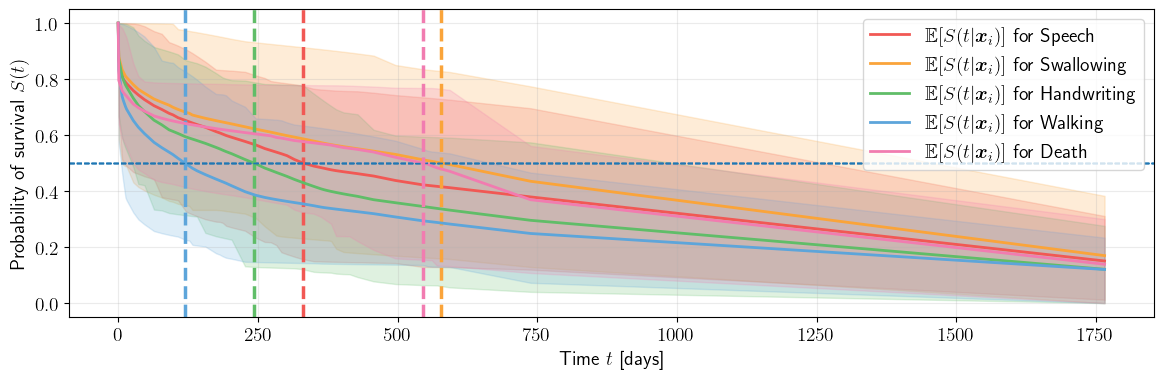

In [79]:
plt.figure(figsize=(14, 4))
event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking', 'Death']
for i, (event_name, mean_output, lower_output, upper_output, sample_tte, event_median_tte) in \
    enumerate(zip(event_names, event_mean_outputs, event_lower_outputs,
                  event_upper_outputs, event_sample_tte, event_median_survival_times)):
        
    plt.plot(time_bins, mean_output, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{x}_{i})]$" + f" for {event_name}", color=TFColor[i])
    plt.fill_between(time_bins, upper_output, lower_output, color=TFColor[i], alpha=0.2)
    plt.axhline(y=0.5, linestyle= "dashed", linewidth=1)
    plt.axvline(x=int(event_median_tte), linestyle= "dashed", linewidth=2.5, color=TFColor[i])

plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ [days]")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()
plt.close()